In this notebook we will store and augmenatate the data and create anchor boxes for the tank oil dataset

Importing libraries

# Storing data as pandas dataframe

In [1]:
import warnings
warnings.filterwarnings('ignore') 
import sys
import os
import shutil
import random 
import math
import pandas as pd
from tqdm import tqdm
import json
from sklearn import model_selection
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np


In [ ]:
!gdown --id 1JA5YtBcL2462ekmyHxZcyj6Y6m3aiKt1

In [ ]:
!unzip  'Oil Tanks.zip'


In [4]:
!mv 'Oil Tanks' 'oil'

In [175]:

json_path = '/content/oil/labels.json'
df = pd.read_json(json_path)


In [176]:
# filtered label with 'Skip'
df = df[df['label']!='Skip']    

In [177]:
def compute_max_min_coordinates(geometry):
    '''
    This function takes the list of dictionaries
    Example: "geometry": [{"x": 103, "y": 310}, {"x": 103, "y": 334}, 
    {"x": 133, "y": 334}, {"x": 133, "y": 310}]}
    kind of object from which we fetch x and y coordinates and store the x_min,
    x_max,y_min and y_max as needed by opencv
    '''
    # variable to store x and y values
    x_val = []
    y_val = []
    # iterate every list of dictionaries
    for i in geometry:
      # storing the values of the x and y coordinates
      x_val.append(i['x'])
      y_val.append(i['y'])
    # sort the x and y values
    x_val.sort()
    y_val.sort()
    # store the min and max values
    x_min = x_val[0]
    x_max = x_val[-1]
    y_min = y_val[0]
    y_max = y_val[-1]
    return [x_min,y_min,x_max,y_max]


In [178]:
def extract(dataframe,dir_path):
  complete_path = []
  labels = {'Floating Head Tank':0,'Tank':1,'Tank Cluster':2}
  classes = []
  bounding_box = []
  for index,row in dataframe.iterrows():
    # finding the complete path and appending in complete_path
    complete_path.append(dir_path + os.path.sep+row['file_name'])
    # compute each row  label
    # append in classes label 
    # find the min max coordinates and append it in bounding box
    each_row_max_min = [compute_max_min_coordinates(i['geometry']) for val in  row['label'] for i in row['label'][val] ]
    each_row_label = [val for val in  row['label'] for i in row['label'][val] ]
    bounding_box.append(each_row_max_min)
    classes.append(each_row_label)
        
  return complete_path,classes,bounding_box 

In [179]:
cp,cl,bb =  extract(df,'/content/oil/image_patches')

In [180]:
df2=pd.DataFrame()

In [181]:
df2['file_name'] = cp

In [182]:
df2['classes'] = cl

In [183]:
df2['bounding_box'] = bb

In [184]:
df2

,file_name,classes,bounding_box
0,/content/oil/image_patches/01_0_4.jpg,"[Tank, Tank]","[[438, 254, 455, 271], [388, 259, 408, 279]]"
1,/content/oil/image_patches/01_2_1.jpg,"[Tank, Tank, Tank, Tank]","[[103, 310, 133, 334], [265, 315, 289, 338], [..."
2,/content/oil/image_patches/01_2_2.jpg,"[Tank, Tank, Tank]","[[24, 299, 82, 352], [151, 303, 209, 355], [27..."
3,/content/oil/image_patches/01_2_3.jpg,[Tank],"[[52, 308, 111, 364]]"
4,/content/oil/image_patches/01_2_4.jpg,[Tank],"[[153, 416, 214, 474]]"
...,...,...,...
1824,/content/oil/image_patches/99_6_1.jpg,[Floating Head Tank],"[[69, 450, 159, 514]]"
1825,/content/oil/image_patches/99_6_4.jpg,[Floating Head Tank],"[[19, 415, 97, 482]]"
1826,/content/oil/image_patches/99_7_1.jpg,[Floating Head Tank],"[[67, 0, 158, 56]]"
1827,/content/oil/image_patches/100_4_6.jpg,"[Floating Head Tank, Floating Head Tank]","[[30, 337, 74, 392], [31, 489, 74, 513]]"


In [185]:
df2.to_csv('data.csv')

Splitting data into test and train

In [186]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df2, test_size=0.10, random_state=42)

In [187]:
X_train.to_csv('train.csv')
X_test.to_csv('test.csv')

Generating TFRecord Data:
This is needed for yolo as it takes , the dataset in this format, the benefit is that we can write image data in binary format so that it would be easy for it serialize and deserialize also in tpu's this data canbe sharded between different workers.

In [188]:
import  PIL
import ast

In [189]:
# # https://blog.roboflow.com/create-tfrecord/
def tf_train_example(row_in_dataframe):
    complete_path = row_in_dataframe['file_name']
    with open(complete_path,'rb') as fp:
      bin_img = fp.read()
    label_dict = { 'Floating Head Tank': 0, 'Tank Cluster': 1,'Tank': 2}
    image = PIL.Image.open(complete_path)
    width, height = image.size


    xmins = [] #list of all xmin in a an image
    xmaxs = [] #list of all xmax in a an image
    ymins = [] #list of all ymin in a an image
    ymaxs = [] #list of all ymax in a an image
    classes_text = [] #list of all object name in a an image
    classes = [] #list of all object label in a an image

    #coverting string list into a Python list
    bb = row_in_dataframe['bounding_box']
    labels = row_in_dataframe['classes']

    for bb1, label in zip(bb, labels):
        xmins.append(float(bb1[0]) / width)
        ymins.append(float(bb1[1]) / height)
        xmaxs.append(float(bb1[2]) / width)
        ymaxs.append(float(bb1[3]) / height)

        classes_text.append(label.encode('utf8'))
        classes.append(label_dict[label])
    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            row_in_dataframe['file_name'].encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bin_img])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpeg'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }))
    return example


In [190]:
def generate_tfdataset(csvfile,out):
    df_ = pd.read_csv(csvfile)
    #coverting string list into a Python list
    # https://www.kite.com/python/docs/ast.literal_eval
    df_['bounding_box'] = df_['bounding_box'].apply(ast.literal_eval)
    df_['classes'] = df_['classes'].apply(ast.literal_eval)

    writer = tf.io.TFRecordWriter(out)
    for  index,row in df_.iterrows(): 
        tf_example = tf_train_example(row)
        writer.write(tf_example.SerializeToString())
    writer.close() #closing TFRecords file


generate_tfdataset('train.csv', 'train.tfrecord')

generate_tfdataset('test.csv', 'test.tfrecord')

# Generate Anchors for yolo

Why we need anchors for yolo ?
We divide a image in grids in yolo , there can be a chance that a grid does not have one object inside it so to cover the limitation of yolo with a grid with one object , with one grid we can say we have k anchors so that there can be maximum k objects in that grid and with different dimension , so to choose a particular anchor for which we can say that object reside on that is calculated by finding out the max IOU (Intersection over union) , once we know that anchor would be defined for that object. 

This is taken from https://github.com/AlexeyAB/darknet/blob/master/scripts/gen_anchors.py to generate anchors original paper https://arxiv.org/pdf/1612.08242.pdf

In [191]:
# using k=9 clusters as in original paper it shows 9 cluster gave the best
# result
width_in_cfg_file = 512
height_in_cfg_file = 512


In [192]:
# taken from 
# https://github.com/AlexeyAB/darknet/blob/master/scripts/gen_anchors.py
def IOU(x,centroids):
    similarities = []
    k = len(centroids)
    for centroid in centroids:
        c_w,c_h = centroid
        w,h = x
        if c_w>=w and c_h>=h:
            similarity = w*h/(c_w*c_h)
        elif c_w>=w and c_h<=h:
            similarity = w*c_h/(w*h + (c_w-w)*c_h)
        elif c_w<=w and c_h>=h:
            similarity = c_w*h/(w*h + c_w*(c_h-h))
        else: #means both w,h are bigger than c_w and c_h respectively
            similarity = (c_w*c_h)/(w*h)
        similarities.append(similarity) # will become (k,) shape
    return np.array(similarities) 

In [193]:
def avg_IOU(X,centroids):
    n,d = X.shape
    sum = 0.
    for i in range(X.shape[0]):
        #note IOU() will return array which contains IoU for each centroid and X[i] // slightly ineffective, but I am too lazy
        sum+= max(IOU(X[i],centroids)) 
    return sum/n



In [194]:
def write_anchors_to_file(centroids,X,anchor_file):
    f = open(anchor_file,'w')
    
    anchors = centroids.copy()
    print(anchors.shape)

    for i in range(anchors.shape[0]):
        anchors[i][0]*=width_in_cfg_file/32.
        anchors[i][1]*=height_in_cfg_file/32.
         

    widths = anchors[:,0]
    sorted_indices = np.argsort(widths)

    print('Anchors = ', anchors[sorted_indices])
        
    for i in sorted_indices[:-1]:
        f.write('%0.2f,%0.2f, '%(anchors[i,0],anchors[i,1]))

    #there should not be comma after last anchor, that's why
    f.write('%0.2f,%0.2f\n'%(anchors[sorted_indices[-1:],0],anchors[sorted_indices[-1:],1]))
    
    f.write('%f\n'%(avg_IOU(X,centroids)))
    print()

In [195]:
def kmeans(X,centroids,eps,anchor_file):
    
    N = X.shape[0]
    iterations = 0
    k,dim = centroids.shape
    prev_assignments = np.ones(N)*(-1)    
    iter = 0
    old_D = np.zeros((N,k))

    while True:
        D = [] 
        iter+=1           
        for i in range(N):
            d = 1 - IOU(X[i],centroids)
            D.append(d)
        D = np.array(D) # D.shape = (N,k)
        
        print("iter {}: dists = {}".format(iter,np.sum(np.abs(old_D-D))))
            
        #assign samples to centroids 
        assignments = np.argmin(D,axis=1)
        
        if (assignments == prev_assignments).all() :
            print("Centroids = ",centroids)
            write_anchors_to_file(centroids,X,anchor_file)
            return

        #calculate new centroids
        centroid_sums=np.zeros((k,dim),np.float)
        for i in range(N):
            centroid_sums[assignments[i]]+=X[i]        
        for j in range(k):            
            centroids[j] = centroid_sums[j]/(np.sum(assignments==j))
        
        prev_assignments = assignments.copy()     
        old_D = D.copy()  



In [196]:

    
row_in_dataframe_dims = []
eps = 0.005
for  index,row in df2.iterrows():
  for bb in  row['bounding_box']:
    w = bb[2]-bb[0]
    h = bb[3]-bb[1]

    row_in_dataframe_dims.append(tuple(map(float,(w,h))))
row_in_dataframe_dims = np.array(row_in_dataframe_dims)
print ("shape==",row_in_dataframe_dims.shape[0])
num_clusters = 9
output_dir = os.getcwd()  
anchor_file = join(output_dir,'anchors%d.txt'%(num_clusters))
indices = [ random.randrange(row_in_dataframe_dims.shape[0]) for i in range(num_clusters)]
centroids = row_in_dataframe_dims[indices]
print  ("intial centroids==",centroids)
kmeans(row_in_dataframe_dims,centroids,eps,anchor_file)
print('centroids.shape', centroids.shape)


shape== 9051
intial centroids== [[ 28.  25.]
 [ 55.  52.]
 [ 59.  64.]
 [ 77.  17.]
 [ 45.  92.]
 [ 72.  66.]
 [ 52.  56.]
 [157. 122.]
 [ 55.  98.]]
iter 1: dists = 52166.58541420452
iter 2: dists = 5097.3577608355645
iter 3: dists = 1528.8189981338812
iter 4: dists = 1083.7914274369812
iter 5: dists = 1089.5682607399108
iter 6: dists = 969.2526339380071
iter 7: dists = 754.0646049847181
iter 8: dists = 631.3917673782931
iter 9: dists = 469.5642419737442
iter 10: dists = 318.98500193522887
iter 11: dists = 271.4395524401286
iter 12: dists = 200.50241521962005
iter 13: dists = 143.05658295653836
iter 14: dists = 198.862801660255
iter 15: dists = 283.84285436541575
iter 16: dists = 335.0525709999282
iter 17: dists = 227.0307161885246
iter 18: dists = 160.89669149674893
iter 19: dists = 128.69645367335238
iter 20: dists = 86.64754774978115
iter 21: dists = 61.64224940334413
iter 22: dists = 58.798757768638026
iter 23: dists = 31.426242661383043
iter 24: dists = 15.20248103161278
iter 25:

# Yolov3

Taken from https://github.com/zzh8829/yolov3-tf2

In [197]:
from absl import logging
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.utils import plot_model
yolo_max_boxes = 100
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]



batch_size =8
size = 416

def load_darknet_weights(model, weights_file, tiny=False):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    layers = YOLOV3_LAYER_LIST

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            # print("{}/{} {}".format(sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.get_input_shape_at(0)[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()


def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)


In [198]:
from absl import flags
from absl.flags import FLAGS
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)

yolo_max_boxe = 100
yolo_iou_threshold = 0.5
yolo_score_threshold = 0.5
size=416
'''
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416
'''
yolo_anchors = np.array([(15, 15), (24, 24), (27, 73), (36, 36), (52, 52),\
                         (72, 26), (72, 66), (87, 94), (125, 122)],\
                        np.float32) / 512

yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])



def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x


def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x


def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x


def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv





In [199]:
def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv
#yolo_head
def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

def YoloV3(size, channels, classes, masks=yolo_anchor_masks):
    x = inputs = Input([size, size, channels], name='input')

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    #channel 1024
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    #channel 512
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    #channel 256
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    return Model(inputs, (output_0, output_1, output_2), name='yolov3')


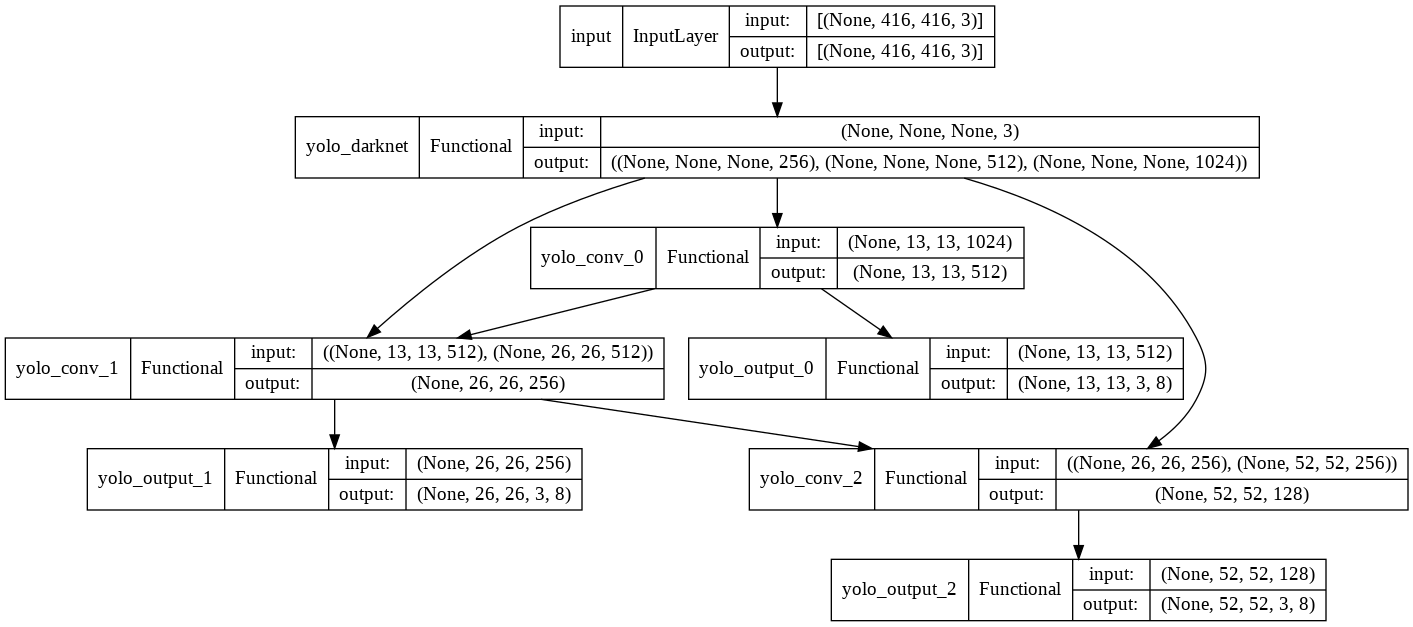

In [200]:
model = YoloV3(size, 3, 3)
plot_model(model, 'tfmodel.png', show_shapes=True)

In [201]:
def yolo_boxes(pred, anchors, classes):
    grid_size = tf.shape(pred)[1:3] 
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy) 
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)

    pred_box = tf.concat((box_xy, box_wh), axis=-1)  
    grid = tf.meshgrid(tf.range(grid_size[1]), tf.range(grid_size[0]))

    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  
    box_xy = (box_xy + tf.cast(grid, tf.float32)) / tf.cast(grid_size, tf.float32) 
    box_wh = anchors * tf.exp(box_wh) 

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1) 

    
    return bbox, objectness, class_probs, pred_box

In [202]:
def broadcast_iou(box_1, box_2):
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)

    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h 
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)


In [203]:
def YoloLoss(anchors, classes=3, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2] 
        pred_wh = pred_xywh[..., 2:4] 

        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)

        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]


        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.logical_or(tf.math.is_inf(true_wh),
                                         tf.math.is_nan(true_wh)),
                           tf.zeros_like(true_wh), true_wh)

        obj_mask = tf.squeeze(true_obj, -1) 
        best_iou = tf.map_fn(
            lambda x: tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(
                x[1], tf.cast(x[2], tf.bool))), axis=-1),
            (pred_box, true_box, obj_mask),
            tf.float32)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

In [204]:
def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

In [205]:


# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md#conversion-script-outline-conversion-script-outline
# Commented out fields are not required in our project
IMAGE_FEATURE_MAP = {
    # 'image/width': tf.io.FixedLenFeature([], tf.int64),
    # 'image/height': tf.io.FixedLenFeature([], tf.int64),
    # 'image/filename': tf.io.FixedLenFeature([], tf.string),
    # 'image/source_id': tf.io.FixedLenFeature([], tf.string),
    # 'image/key/sha256': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    # 'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    # 'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    # 'image/object/difficult': tf.io.VarLenFeature(tf.int64),
    # 'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    # 'image/object/view': tf.io.VarLenFeature(tf.string),
}

def parse_tfrecord(tfrecord, class_table, size):
    #Parses a single Example proto.
    x = tf.io.parse_single_example(tfrecord, IMAGE_FEATURE_MAP)
    #Decoding a JPEG-encoded image to a uint8 tensor.
    x_train = tf.image.decode_jpeg(x['image/encoded'], channels=3)
    print ("x_train=",x_train)
    #Resizing image to fixed side
    x_train = tf.image.resize(x_train, (size, size))

    #Converting a SparseTensor into a dense tensor. and reading object class
    #names
    class_text = tf.sparse.to_dense(
        x['image/object/class/text'], default_value='')
    labels = tf.cast(class_table.lookup(class_text), tf.float32)
    y_train = tf.stack([tf.sparse.to_dense(x['image/object/bbox/xmin']),
                        tf.sparse.to_dense(x['image/object/bbox/ymin']),
                        tf.sparse.to_dense(x['image/object/bbox/xmax']),
                        tf.sparse.to_dense(x['image/object/bbox/ymax']),
                        labels], axis=1)
  
    paddings = [[0, yolo_max_boxes - tf.shape(y_train)[0]], [0, 0]]
    y_train = tf.pad(y_train, paddings)
    print ("x_train=",x_train)
    print ("y_train=",y_train)

    return x_train, y_train

def load_tfrecord_dataset(file_pattern, class_file, size=size):
    LINE_NUMBER = -1  # TODO: use tf.lookup.TextFileIndex.LINE_NUMBER
    #Creating a generic hash table that is immutable once initialized 
    #For more info vist:
    #https://www.tensorflow.org/api_docs/python/tf/lookup/TextFileInitializer
    class_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
        class_file, tf.string, 0, tf.int64, LINE_NUMBER, delimiter="\n"), -1)

    #creating a dataset of files matching a pattern
    files = tf.data.Dataset.list_files(file_pattern)
    print ("files=",files)
    #Mapping dataset to TFRecordsDataset and used flat_map to make sure that
    #order of dataset stays the same. For more info 
    #visit: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
    dataset = files.flat_map(tf.data.TFRecordDataset)
    #Parsing each records of dataset
    print (dataset.map(lambda x: parse_tfrecord(x, class_table, size)))
    return dataset.map(lambda x: parse_tfrecord(x, class_table, size))

def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs):
    # y_true: (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # y_true_out: (N, grid, grid, anchors, [x, y, w, h, obj, class])
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, size):
    y_outs = []
    grid_size = size // 32

    # calculate anchor index for true boxes
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                     (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs))
        grid_size *= 2

    return tuple(y_outs)



In [206]:
labels = ['Floating Head Tank\n','Tank\n','Tank Cluster\n']
with open('label.names','w') as fp:
  fp.writelines(labels)

In [207]:
train_dataset = load_tfrecord_dataset('train.tfrecord', 'label.names')

train_dataset = train_dataset.shuffle(buffer_size=512)
train_dataset = train_dataset.batch(batch_size)

train_dataset = train_dataset.map(lambda x, y: (
    transform_images(x, size),
    transform_targets(y, yolo_anchors, yolo_anchor_masks, size)))
train_dataset = train_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

print (train_dataset)

files= <ShuffleDataset shapes: (), types: tf.string>
x_train= Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
x_train= Tensor("resize/Squeeze:0", shape=(416, 416, 3), dtype=float32)
y_train= Tensor("Pad:0", shape=(None, 5), dtype=float32)
<MapDataset shapes: ((416, 416, 3), (None, 5)), types: (tf.float32, tf.float32)>
x_train= Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
x_train= Tensor("resize/Squeeze:0", shape=(416, 416, 3), dtype=float32)
y_train= Tensor("Pad:0", shape=(None, 5), dtype=float32)
<PrefetchDataset shapes: ((None, 416, 416, 3), ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6), (None, 52, 52, 3, 6))), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>


In [208]:
for batch, (images, labels) in enumerate(train_dataset):
  print (images.shape)
  #print (labels)

(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 3)
(8, 416, 416, 

In [209]:
val_dataset = load_tfrecord_dataset('test.tfrecord', 'label.names')
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.map(lambda x, y: (
    transform_images(x, size),
    transform_targets(y, yolo_anchors, yolo_anchor_masks, size)))
print(val_dataset)

files= <ShuffleDataset shapes: (), types: tf.string>
x_train= Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
x_train= Tensor("resize/Squeeze:0", shape=(416, 416, 3), dtype=float32)
y_train= Tensor("Pad:0", shape=(None, 5), dtype=float32)
<MapDataset shapes: ((416, 416, 3), (None, 5)), types: (tf.float32, tf.float32)>
x_train= Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
x_train= Tensor("resize/Squeeze:0", shape=(416, 416, 3), dtype=float32)
y_train= Tensor("Pad:0", shape=(None, 5), dtype=float32)
<MapDataset shapes: ((None, 416, 416, 3), ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6), (None, 52, 52, 3, 6))), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>


In [210]:
from absl import app, flags, logging
from absl.flags import FLAGS

import tensorflow as tf
import numpy as np
import cv2
import time
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

#from yolov3_tf2.utils import freeze_all
#import yolov3_tf2.dataset as dataset

learning_rate = 1e-3
def setup_model():
    ############################# TODO remove dep
    # load pretrained weight
    # https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
    pre_model = YoloV3(size,3, classes=80)
    load_darknet_weights(pre_model,'/content/yolov3.weights')
    model = YoloV3(size,3, classes=3)
    model.get_layer('yolo_darknet').set_weights(
        pre_model.get_layer('yolo_darknet').get_weights())
    freeze_all(model.get_layer('yolo_darknet'))
    anchors = yolo_anchors
    anchor_masks = yolo_anchor_masks

    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    loss = [YoloLoss(anchors[mask], classes=3)
            for mask in anchor_masks]

    model.compile(optimizer=optimizer, loss=loss)

    return model, optimizer, loss, anchors, anchor_masks

model, optimizer, loss, anchors, anchor_masks = setup_model()


In [211]:
!gdown --id 1Bc8LoqGxYsJLOxwFVHvryrvqlqufIxs0

Downloading...
From: https://drive.google.com/uc?id=1Bc8LoqGxYsJLOxwFVHvryrvqlqufIxs0
To: /content/yolov3.weights
100% 248M/248M [00:01<00:00, 196MB/s]


In [212]:
from absl import app, flags, logging
from absl.flags import FLAGS

import tensorflow as tf
import numpy as np
import cv2
import time
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

#from yolov3_tf2.utils import freeze_all
#import yolov3_tf2.dataset as dataset

learning_rate = 1e-3
def setup_model():
    ############################# TODO remove dep
    # load pretrained weight
    # https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
    pre_model = YoloV3(size,3, classes=80)
    load_darknet_weights(pre_model,'/content/yolov3.weights')
    model = YoloV3(size,3, classes=3)
    model.get_layer('yolo_darknet').set_weights(
        pre_model.get_layer('yolo_darknet').get_weights())
    freeze_all(model.get_layer('yolo_darknet'))
    anchors = yolo_anchors
    anchor_masks = yolo_anchor_masks

    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    loss = [YoloLoss(anchors[mask], classes=3)
            for mask in anchor_masks]

    model.compile(optimizer=optimizer, loss=loss)

    return model, optimizer, loss, anchors, anchor_masks

model, optimizer, loss, anchors, anchor_masks = setup_model()

avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
mode =' '
epochs =10
if mode == 'eager_tf':
        # Eager mode is great for debugging
        # Non eager graph mode is recommended for real training
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

        for epoch in range(1, epochs + 1):
            for batch, (images, labels) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    outputs = model(images, training=True)
                    regularization_loss = tf.reduce_sum(model.losses)
                    pred_loss = []
                    for output, label, loss_fn in zip(outputs, labels, loss):
                        pred_loss.append(loss_fn(label, output))
                    total_loss = tf.reduce_sum(pred_loss) + regularization_loss

                grads = tape.gradient(total_loss, model.trainable_variables)
                optimizer.apply_gradients(
                    zip(grads, model.trainable_variables))

                logging.info("{}_train_{}, {}, {}".format(
                    epoch, batch, total_loss.numpy(),
                    list(map(lambda x: np.sum(x.numpy()), pred_loss))))
                avg_loss.update_state(total_loss)

            for batch, (images, labels) in enumerate(val_dataset):
                outputs = model(images)
                regularization_loss = tf.reduce_sum(model.losses)
                pred_loss = []
                for output, label, loss_fn in zip(outputs, labels, loss):
                    pred_loss.append(loss_fn(label, output))
                total_loss = tf.reduce_sum(pred_loss) + regularization_loss

                logging.info("{}_val_{}, {}, {}".format(
                    epoch, batch, total_loss.numpy(),
                    list(map(lambda x: np.sum(x.numpy()), pred_loss))))
                avg_val_loss.update_state(total_loss)

            logging.info("{}, train: {}, val: {}".format(
                epoch,
                avg_loss.result().numpy(),
                avg_val_loss.result().numpy()))

            avg_loss.reset_states()
            avg_val_loss.reset_states()
            model.save_weights(
                'checkpoints/yolov3_train_{}.tf'.format(epoch))
        

model, optimizer, loss, anchors, anchor_masks = setup_model()   
model.summary()
callbacks = [
            ReduceLROnPlateau(verbose=1),
            EarlyStopping(patience=3, verbose=1),
            ModelCheckpoint('checkpoints/yolov3_train_{epoch}.tf',
                            verbose=1, save_weights_only=True),
            #TensorBoard(log_dir='logs')
]

history = model.fit(train_dataset,
                    epochs=20,
                    callbacks=callbacks,
                    batch_size=batch_size,
                    validation_data=val_dataset)



Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 yolo_darknet (Functional)      ((None, None, None,  40620640    ['input[0][0]']                  
                                 256),                                                            
                                 (None, None, None,                                               
                                 512),                                                            
                                 (None, None, None,                                          

In [213]:
model.save('latest_weights.hdf5')

**Plotting ground truth**

In [215]:
os.mkdir('output')

In [216]:
def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        print ("classes",classes[i])
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.52, (30, 0, 0), 2)
    return img

In [217]:
from keras.models import load_model
#model1 = load_model('/content/latest_weights.hdf5')

In [218]:
# taken from previous assginments segmentation
json_path = '/content/oil/labels.json'
f = open(json_path,'r')
# as load takes read iteratively
labels = json.load(f)
print ("Total number of labels",len(labels))
f.close()

Total number of labels 10000


In [219]:
from google.colab.patches import cv2_imshow
              
def plot_image(row):
    
    # https://stackoverflow.com/questions/54054865/given-pixel-label-draw-a-bounding-box-in-python/54070043
    complete_path = row['file_name']
    matrix_label= row['classes']
    matrix = row['bounding_box']
    image = cv2.imread(complete_path)
    for index,value in enumerate(matrix_label):
      cv2.rectangle(image,(matrix[index][0],matrix[index][1]),(matrix[index][2],matrix[index][3]),(0,255,0),2)
      # https://stackoverflow.com/questions/56108183/python-opencv-cv2-drawing-rectangle-with-text#:~:text=You%20can%20use%20cv2.,it%20by%20shifting%20it%20upwards.
      cv2.putText(image, str(matrix_label[index]), (matrix[index][0], matrix[index][1]-1),cv2.FONT_HERSHEY_SIMPLEX,0.5, (255,0,0), 2,cv2.LINE_AA)
    #as cv2_imshow crashes in google colab
    cv2_imshow(image)


In [220]:
df3 = pd.read_csv('test.csv')

In [221]:
df3.iloc[0]['file_name']

'/content/oil/image_patches/05_8_8.jpg'

In [222]:
df3['classes']  = df3['classes'].apply(ast.literal_eval)
df3['bounding_box'] = df3['bounding_box'].apply(ast.literal_eval)


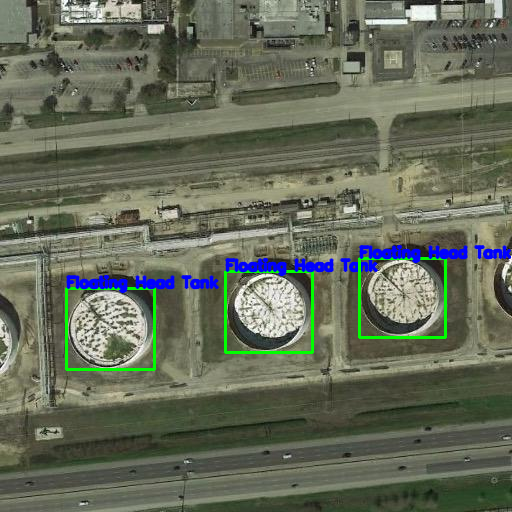

In [223]:
plot_image(df3.iloc[0])

In [224]:
def yolo_nms(outputs, anchors, masks, classes):
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    # If we only have one class, do not multiply by class_prob (always 0.5)
    if classes == 1:
        scores = confidence
    else:
        scores = confidence * class_probs

    dscores = tf.squeeze(scores, axis=0)
    scores = tf.reduce_max(dscores,[1])
    bbox = tf.reshape(bbox,(-1,4))
    classes = tf.argmax(dscores,1)
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(
        boxes=bbox,
        scores=scores,
        max_output_size=yolo_max_boxes,
        iou_threshold=yolo_iou_threshold,
        score_threshold=yolo_score_threshold,
        soft_nms_sigma=0.5
    )
    
    num_valid_nms_boxes = tf.shape(selected_indices)[0]

    selected_indices = tf.concat([selected_indices,tf.zeros(yolo_max_boxes-num_valid_nms_boxes, tf.int32)], 0)
    selected_scores = tf.concat([selected_scores,tf.zeros(yolo_max_boxes-num_valid_nms_boxes,tf.float32)], -1)

    boxes=tf.gather(bbox, selected_indices)
    boxes = tf.expand_dims(boxes, axis=0)
    scores=selected_scores
    scores = tf.expand_dims(scores, axis=0)
    classes = tf.gather(classes,selected_indices)
    classes = tf.expand_dims(classes, axis=0)
    valid_detections=num_valid_nms_boxes
    valid_detections = tf.expand_dims(valid_detections, axis=0)

    return boxes, scores, classes, valid_detections



**Detetction**

In [225]:
# image detection 
# taken from detect.py same repo

def detect(image,index=0):
  class_names= { 0:'Floating Head Tank', 1:'Tank Cluster',2:'Tank'}
  img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, size)
  res = model.predict(img)
  total_class = len(class_names.values())
  boxes_0 =  yolo_boxes(res[0], yolo_anchors[yolo_anchor_masks[0]], classes=total_class)
  boxes_1 =  yolo_boxes(res[1], yolo_anchors[yolo_anchor_masks[1]], classes=total_class)
  boxes_2 = yolo_boxes(res[2], yolo_anchors[yolo_anchor_masks[2]], classes=total_class)

  outputs = yolo_nms((boxes_0[:3], boxes_1[:3], boxes_2[:3]), yolo_anchors, yolo_anchor_masks, classes=total_class)
  boxes, scores, classes, nums = outputs
  for i in range(nums[0]):
        print('{}, {}, {}'.format(class_names[int(classes[0][i])],
                                           np.array(scores[0][i]),
                                           np.array(boxes[0][i])))

  img   = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img    = draw_outputs(img, (boxes, scores, classes, nums), class_names)
  output = os.path.join('output',str(index)+'.jpeg')
  cv2.imwrite(output, img)
  cv2_imshow(img)                     

Floating Head Tank, 0.9239010810852051, [0.15265092 0.5656712  0.3115209  0.724452  ]
Floating Head Tank, 0.9158086180686951, [0.71482956 0.5028594  0.87563777 0.6712969 ]
Floating Head Tank, 0.9076492786407471, [0.4409388  0.53161514 0.6187315  0.6934242 ]
classes tf.Tensor(0, shape=(), dtype=int64)
classes tf.Tensor(0, shape=(), dtype=int64)
classes tf.Tensor(0, shape=(), dtype=int64)


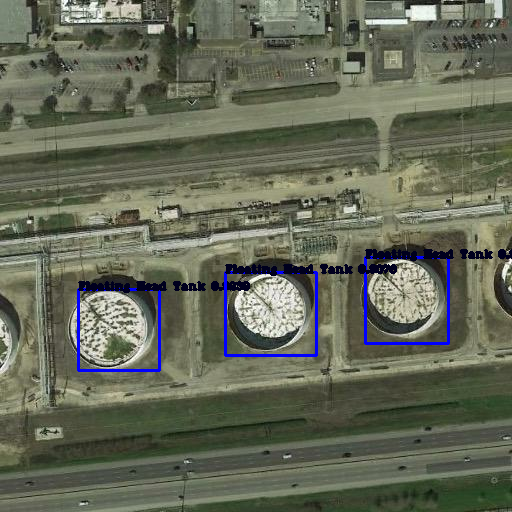

In [226]:
detect(df3.iloc[0]['file_name'])

**Ground truth 2**

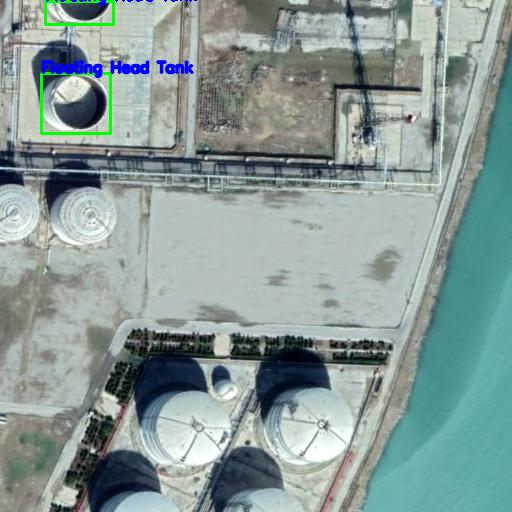

In [234]:
plot_image(df3.iloc[6])

**Detection**

Floating Head Tank, 0.7099964618682861, [ 8.6244121e-02 -1.2958795e-04  2.3099948e-01  5.1229846e-02]
Floating Head Tank, 0.625785768032074, [0.08740941 0.11766174 0.20594093 0.23969486]
classes tf.Tensor(0, shape=(), dtype=int64)
classes tf.Tensor(0, shape=(), dtype=int64)


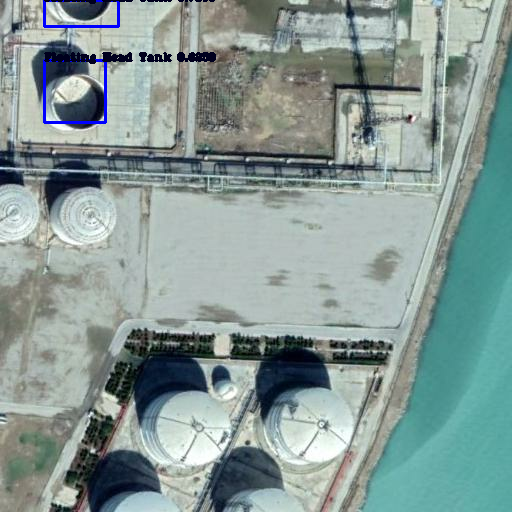

In [235]:
detect(df3.iloc[6]['file_name'])